##  Predicting Fake are Real News - Modeling and testing 


                                By: Muluemebet Ayalew 
                                    June, 2020

In [1]:
# Important libraries
import pandas as pd
import numpy as np
import re # to use regular expression pattern 
import datetime as dt  # to parse to datetime
import string
from scipy import stats

#text processing and visualization
import nltk 
from nltk.tokenize import word_tokenize, regexp_tokenize, TweetTokenizer
from collections import Counter, defaultdict
from nltk.corpus import stopwords          # to access stop words 
from nltk.stem import WordNetLemmatizer, PorterStemmer   # for lemmatization or steming

import spacy
from gensim.corpora.dictionary import Dictionary   # to map token , id and create corpus
from sklearn.manifold import TSNE
from wordcloud import WordCloud,STOPWORDS # to visualize frequeent words 
from gensim.models import  Word2Vec  #  word embeding 
from gensim.models.phrases import Phraser, Phrases # to use for bigram modeling,
from gensim.models.word2vec import LineSentence
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.tfidfmodel import TfidfModel # tfidf using gensim

#for preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # to make word vectors 
from sklearn.model_selection import train_test_split  

# For modeling and evaluation 
from sklearn.naive_bayes import MultinomialNB  # for Naive Baye's  classification
from sklearn.linear_model import LogisticRegression
from sklearn import metrics # to evaluate model performance

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline


## 1) Read the data

In [2]:
true= pd.read_csv("True.csv", parse_dates=["date"])     # the true news data
fake= pd.read_csv("Fake.csv")     # the fake news data 

In [3]:
true.head(3) # the first few rows of real dataframe

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31


In [4]:
true.shape # shape of real news before adding label

(21417, 4)

In [5]:
fake.head() # the first few rows of fake dataframe

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
fake.shape  # shape of fake news before adding label

(23481, 4)

### 1.1) Add labels(fake/true) to the  dataframs

In [7]:
# create a new column called is_fake and label as 0 for true news 
true["label"]="true"

In [8]:
# create a new column called is_fake and label as 1 for fake news 
fake["label"]= "fake"

In [9]:
# parse the date column into datetime. 
#Since it has two datetime format, we need two formats to parse.  
def parsing_datetime(string):
    for f in ("%B %d, %Y", '%d-%b-%y', "%b %d, %Y"): # format  19-Feb-18
        try:
            return dt.datetime.strptime(string, f)
        except ValueError:
            pass
        
# parse the date column of fake dataframe into datetime
fake.date= fake.date.apply(lambda x: parsing_datetime(x))

In [10]:
true.head(3)

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,true
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,true
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,true


In [11]:
fake.head(3)

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,fake


### 1.2)  Merge the real and fake dataframe

In [12]:
# Merge the fake and read dataframe
news= pd.concat([true,fake], axis=0).reset_index() # reset index to have unique index

In [13]:
news.sample(5).head()

,index,title,text,subject,date,label
44619,23202,FBI Director Comey’s ‘Leaked’ Memo Explains Wh...,21st Century Wire says 21WIRE reported on Frid...,Middle-east,2016-10-29,fake
11142,11142,White House welcomes U.S. court ruling on carb...,WASHINGTON (Reuters) - The White House said on...,politicsNews,2016-01-21,true
28925,7508,Kansas Republican Bill Would Give GOP Power T...,"If Kansas Republicans have their way, they wil...",News,2016-03-13,fake
38959,17542,OOPS! Lindsey Vonn Gets Hit With Big Dose Of K...,"Only 3 days ago, Lindsey Vonn told CNN that sh...",left-news,2017-12-09,fake
17905,17905,Afghan-Pakistan border villages brace for Berl...,"CHAMAN/QUETTA, Pakistan (Reuters) - Thousands ...",worldnews,2017-10-10,true


In [14]:
news.index.is_unique # we have unique index 

True

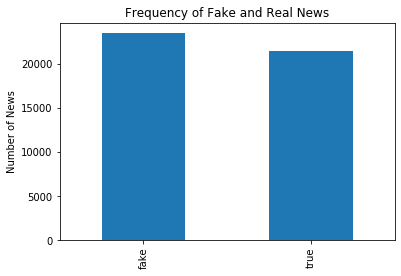

In [15]:
# bar plot the number of fake and real news
_=news.label.value_counts().plot(kind="bar", title="Frequency of Fake and Real News")
_=plt.ylabel("Number of News")


## 2)  Data Cleaning and preprocessing:
Removing html tags, url links, specal characters, punctuations, emoji and stopwords. Though CountVectorizer handles stop words , special characters and punctuation, the cleaning was done before it. 

The function remove_pattern is defiend to remove certain patterns from the text. 

###  Function to remove patterns(emoji, url, html , special characteres, punctuations, .....)

In [16]:
#patterns= [emoji, url, html]
def remove_pattern(text, patterns):
    """The function remove_pattern returns the new string with a set of patterns removed.
       Parameters:
       ------------
       data: the text from which the pattern will be removed
       patterns: is the set of patterns(iterable) we are intereted to remove from the text
       """
           
    for pattern in patterns:
        new= re.sub(pattern, "", text)
        text= new 
    return new

In [17]:
# patterns to be extracted and to be removed from the data 
emoji = "[\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\u2600-\u26FF\u2700-\u27BF\U000024C2-\U0001F251]+"

url= re.compile("https?://\S+|www\.\S+")                     # pattern for url
html= r'<.*?>'                                               # pattern for html tag
num_with_text= r"\S*\d+\S*"                                  # pattern for digit 
punctuation= r"[#@&%$~=\.;:\?,(){}\"\“\”\‘\'\*!\+`^<>\[\]\-]+"      #pattern for punctuations and special characters   
apostroph=r"\’s?"
# collect the patterns 
patterns=[emoji, url, html, num_with_text, punctuation, apostroph]

### 2.1) Clean merged data
At this statage of data cleaning ,the emoji, url links, html tag, digits and special characters and punctuation are removed.

In [18]:
# Clean the title of merged data using regular expression patterns
news_clean_title = news.title.apply(remove_pattern, patterns= patterns)
news_clean_text= news.text.apply(remove_pattern, patterns= patterns)

### Remove stopwords 
Stopwords are worlds commonly appeared in a text with no significant information about it. For example 'a', 'the','of' etc. Gensim library has stopwords and a function to remove stopwords. Here, I implement two step process to remove stopwords. First, using remove_stopwords() from gensim.parsing.preprocessing module. And second, using stopwords from wordcloud module. Since the words in the text are affacted by data cleaning technique such as removing punctutions, we need to format the stopwords in the same way we cleaned the data. For example it has a stopeword "you'll". It will be changed in to "youll" after removing the apostrophe. Thus, the stopewords should have the same format to ignoure them.

In [19]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_multiple_whitespaces, preprocess_documents

In [20]:
# remove stopwords and multiple whitespaces from the news title
nostopword_title= news_clean_title.apply(remove_stopwords).apply(strip_multiple_whitespaces) 
# remove stopwords and multiple whitespaces from the news title
nostopword_text= news_clean_text.apply(remove_stopwords).apply(strip_multiple_whitespaces)  

### Tokenization 
Split the text into words by white space. Here, the text are also converted into lowercase and stopwords are removed for the second time after the punctuations were removed. 

In [21]:
formated_stopword=[re.sub("\'", "", word)  for word in STOPWORDS] # stopwords are from wordcloud library 
formated_stopword # remove apostrophe from stopwords to match with stopwords in the text after punctuations removed 
def tokenize_without_stopwords(data): # remove stopword, make lower case , split the text a
    tokens=[]
    for word in data.lower().split():
        if word not in formated_stopword:
            tokens.append(word)
    return tokens      

**Datasets for phrase modeling and word embeding :** The following tokenized datasets will be used later for phrase modeling. The wordembeding is also done based on this data sets.

In [22]:
# geting word tokens in lower case without stopwords, this is used later for phrase modeling and word embeding 
data_title= nostopword_title.apply(tokenize_without_stopwords)

In [23]:
# geting word tokens in lower case without stopwords, this data is later used for phrase modeling and word embeding  
data_text=nostopword_text.apply(tokenize_without_stopwords)

In [24]:
data_title.head(3)  # look at the tokenized data

0    [us, budget, fight, looms, republicans, flip, ...
1    [us, military, accept, transgender, recruits, ...
2    [senior, us, republican, senator, let, mr, mue...
Name: title, dtype: object

**Datasets to make  countvector and tfidf:**
Make ready the data for modeling by concatenating the tokenized words into a single text.
These data are used later for modeling using countvector and tfidf.

In [25]:
# make ready the data for modeling by concatenating the tokenized words into a single text.
#These data are used later for modeling using countvector  and tfidf  
clean_title = data_title.apply(lambda x: " ".join(x))
clean_text = data_text.apply(lambda x:" ".join(x))

In [26]:
clean_title.head(3) # look at the cleaned titles 

0    us budget fight looms republicans flip fiscal ...
1    us military accept transgender recruits monday...
2      senior us republican senator let mr mueller job
Name: title, dtype: object

### 2.2)  Creating Custom  Word Embeddings using Word2Vec
Though it is possible to have pre-trainied models using spacy or gensim, here I am interested to create a custom word embeding to see if there is performance diffence.


### Phrase detection 
The text is coverted into lowercase to avoid case sensitivity. Make sure that the new data to be transformed using this model has to be in lower case before transforming. 

In [31]:
# phrases = Phrases(sentences, min_count=1, threshold=1)
common_terms = ["of", "with", "without", "and", "or", "the", "a"]
# Create the relevant phrases from the list of sentences:
phrases = Phrases(data_title, common_terms=common_terms)
# The Phraser object is used to transform sentences
bigram_ttl = Phraser(phrases)

all_title = list(bigram_ttl[data_title])

In [32]:
all_title[:3]

[['us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script'],
 ['us', 'military', 'accept', 'transgender', 'recruits', 'monday', 'pentagon'],
 ['senior', 'us', 'republican_senator', 'let', 'mr', 'mueller', 'job']]

In [33]:
bigram_ttl[["president","barack","obama"]] # check for using new word list

['president', 'barack_obama']

In [34]:
phrases = Phrases(data_text, common_terms=common_terms)
# The Phraser object is used to transform sentences
bigram_txt = Phraser(phrases)

all_text = list(bigram_txt[data_text])

In [35]:
all_text[0][:5] #the first row(news) with some tokens 

['washington_reuters', 'head', 'conservative', 'republican', 'faction']

In [ ]:
 # Save / load an exported collocation model
#bigram_txt.save("bigram_model_txt.pkl")
#bigram_reloaded = Phraser.load("bigram_model_txt.pkl")
#bigram_reloaded[["donald", "trump" ,"is", "a", "president"]]  # apply the exported model to a sentence


### Lemmatization and stemming
Lemmatization and stemming was applied for the data set. However, some words were modefied by lemmatization and phrase detection was not efficent after stemming. Therefore, the results of lemmatization and stemming were not included in the next step of the  analysis. 

In [36]:

porter_stemmer = PorterStemmer() # from nltk.stem library
def stemming(doc):
    """returns the stemming list of words"""
    stem=[]
    for word in doc:
        stem.append(porter_stemmer.stem(word))
    return stem


lemmatizer = WordNetLemmatizer() # from nltk.stem library
def lemmatize(doc):
    """returns lemmatized list of words"""
    lemma=[]
    for word in doc:
        lemma.append(lemmatizer.lemmatize(word))
    return lemma

In [37]:
data_title_stem =[stemming(doc) for doc in all_title] # stemming the words in the title after phrase modeling

In [38]:
data_text_stem =[stemming(doc) for doc in all_text] # stemming the words in the text 

In [39]:
data_title_stem[:3]

[['us', 'budget', 'fight', 'loom', 'republican', 'flip', 'fiscal', 'script'],
 ['us', 'militari', 'accept', 'transgend', 'recruit', 'monday', 'pentagon'],
 ['senior', 'us', 'republican_sen', 'let', 'mr', 'mueller', 'job']]

In [40]:
data_title_lemma=data_title.apply(lemmatize)

In [41]:
data_title_lemma.head(3) # lemmatization removes 's' from 'us' and make it 'u' doesn't make sense 

0    [u, budget, fight, loom, republican, flip, fis...
1    [u, military, accept, transgender, recruit, mo...
2    [senior, u, republican, senator, let, mr, muel...
Name: title, dtype: object

###  Word2Vec

In [42]:
# word2vec representation of words in the news title 
w2v_title = Word2Vec(all_title, 
                 min_count=3,   # Ignore words that appear less than this
                 size=200,      # Dimensionality of word embeddings
                 workers=2,     # Number of processors (parallelisation)
                 window=5,      # Context window for words during training
                 iter=30)    

In [43]:
# word2vec representation of words in the news text 
w2v_text = Word2Vec(all_text, 
                 min_count=3,   # Ignore words that appear less than this
                 size=200,      # Dimensionality of word embeddings
                 workers=2,     # Number of processors (parallelisation)
                 window=5,      # Context window for words during training
                 iter=30)  

In [44]:
print("Size of word2vector for title of news  :", w2v_title) # shape of the word2vector
print("Size of word2vector for text of news :",w2v_text)

Size of word2vector for title of news  : Word2Vec(vocab=13993, size=200, alpha=0.025)
Size of word2vector for text of news : Word2Vec(vocab=120808, size=200, alpha=0.025)


In [45]:
#save the model
w2v_text.save("w2v_text")
#txtw2v= Word2Vec.load("w2v_text") # toload the saved word2vec

In [46]:
w2v_text.wv.most_similar(["us"])

[('united_states', 0.5919766426086426),
 ('obama_administration', 0.39245516061782837),
 ('pentagon', 0.37952154874801636),
 ('american', 0.37035509943962097),
 ('countries', 0.36579960584640503),
 ('washington', 0.3629639744758606),
 ('openended', 0.362476646900177),
 ('iran_complying', 0.3541705310344696),
 ('discourage_imports', 0.33896613121032715),
 ('impose_targeted', 0.32720041275024414)]

In [47]:
w2v_text.wv.__getitem__("us") ;# see word vector for 'us'

In [48]:
vocabulary=w2v_text.wv.index2word
vocabulary[:8] # list of words 

['s', 'said', 'trump', 'us', 'people', 'president', 'government', 't']

###  Convert  Word2vec to feature vectors  
To use word vectors obtained from word2vec, the following functions are defined. Frist, the vectors of each word found in a news are summed up and then divided the number of words appeared in a news(the first function does this). Then, we do this for the entire data set(the second function). 

In [49]:
# This code is taken from a web and adapted a littel bit 
def average_word_vectors(words, model, vocabulary, num_features):
    """returns mean feature vector for each news"""
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words: # loop over words in a tokenized news
        if word in vocabulary: # check if the word in the vocabulary of word2vec
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv.__getitem__(word)) # add vectors in a
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector


def averaged_word_vectorizer(corpus, model, num_features):
    """returns mean feature vector for the whole data set"""
    
    vocabulary = set(model.wv.index2word) #vocabulary of word2vec
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [50]:
feature_size=200
corpus_txt= all_text # list of words in list of news
corpus_ttl=all_title # list of list for words 

In [51]:
# get document level embeddings
w2v_feature_array_ttl = averaged_word_vectorizer(corpus=corpus_ttl, model=w2v_title,
                                             num_features=feature_size)
w2v_feature_ttl= pd.DataFrame(w2v_feature_array_ttl)

In [52]:
# get document level embeddings
w2v_feature_array_txt = averaged_word_vectorizer(corpus=corpus_txt, model=w2v_text,
                                             num_features=feature_size)
w2v_feature_txt= pd.DataFrame(w2v_feature_array_txt)

In [53]:
# save the feature vectors 
w2v_feature_ttl.to_csv("w2v_feature_ttl.csv", index=False)
w2v_feature_txt.to_csv("w2v_feature_txt.csv", index=False)

In [54]:
w2v_feature_txt.head(3)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.153727,-0.732860,0.303991,0.720534,-0.305186,-0.015977,0.153944,-0.502959,0.692310,0.311424,...,0.083251,0.638944,0.070788,-0.225303,-0.504064,0.370588,0.644337,-0.511604,0.106932,-0.076643
1,0.087173,-0.139868,-0.287196,0.867798,-0.521753,0.216526,0.278204,-0.230697,0.408122,-0.019542,...,-0.124385,0.188996,0.043933,-0.589713,-0.328999,0.087015,0.391701,-0.511506,0.000607,0.012462
2,-0.370391,-0.587086,0.024770,0.645089,-0.540356,-0.335689,0.917892,-0.367188,0.829467,0.326747,...,-0.071384,0.191012,0.222434,-0.719496,0.003930,-0.077755,0.140970,-0.229202,0.171507,-0.244885


In [44]:
#to load the saved data
w2v_feature_ttl=pd.read_csv("w2v_feature_ttl.csv")
w2v_feature_txt=pd.read_csv("w2v_feature_txt.csv")

## 5)  Split the data into training and test data

### 5.1) without cleaning the data 

In [55]:
X= news.drop(["subject","date", "label"], axis=1) # potential predictors 
y= news["label"]              # outcome variable
# Split the data into training and test data
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.3, random_state=40, stratify=y)

In [56]:
print("X-train", X_train.shape)
print("y-train", y_train.shape)

print("X-test", X_test.shape)
print("y-test", y_test.shape)

X-train (31428, 3)
y-train (31428,)
X-test (13470, 3)
y-test (13470,)


### 5.2) With cleaned data

In [57]:
X_ttl=clean_title 
X_txt=clean_text

y= news["label"]  # outcome variable

# Split the data into training and test data for title
X_train_ttl, X_test_ttl, y_train_ttl, y_test_ttl= train_test_split(X_ttl, y, test_size=0.3,random_state=40, stratify=y)

# Split the data into training and test data for text
X_train_txt, X_test_txt, y_train_txt, y_test_txt= train_test_split(X_txt, y, test_size=0.3,random_state=40, stratify=y)


In [58]:
# check the split 
print("X-train", X_train_ttl.shape)
print("y-train", y_train_ttl.shape)
print("X-test", X_test_ttl.shape)
print("y-test", y_test_ttl.shape)

X-train (31428,)
y-train (31428,)
X-test (13470,)
y-test (13470,)


### 5.3) With word2vec features

In [59]:
X_train_w2v_ttl, X_test_w2v_ttl, y_train_w2v_ttl, y_test_w2v_ttl\
                        =train_test_split(w2v_feature_ttl, y, test_size=0.3, random_state=40, stratify=y)

X_train_w2v_txt, X_test_w2v_txt, y_train_w2v_txt, y_test_w2v_txt\
                        =train_test_split(w2v_feature_txt,y, test_size=0.3,random_state=40, stratify=y)

## 6) Making Classification Models

A total of 18 models were fitted with differnt senarios. The first 16 were made with a combination of without cleaned data or with cleaned data, using word count or tfidf, and using logistic regression or multinomial naive bayes. The last two are made using vectores derived from word embeding technique.
Hyperparameters for logistic regression and multinomial naive bayes were tuned using grid search cross validation. The regularization parameter "C" for logistic regression is set to 0.8 for all models for simplicity as it has very similar similar result with the tured values. The parameters used for multinomial naive bayes are obtained from grid search and the detained is found in section 6.5(Parameter tunning).

In [60]:
###
def get_vector(x_train, x_test, vectorizer):
    """Returns the vector of training and test data from the given column using the specified vectorizor.
    
    parameter:
    ----------------
            X_train/X_test: training and test data, respectively
            vectorizore: could be countVectorizer or TfidfVectorizer to vectorize the text.
    """        
    #Instantiate CountVectorizer object 
    count_v= vectorizer(min_df=3, stop_words="english")

    # Transform the training data using only the given column values
    count_train = count_v.fit_transform(x_train)

    # Transform the test data using only the given column values
    count_test = count_v.transform(x_test)
    
    return count_train, count_test


def model_vect(x_train, x_test, ytrain, ytest, vectorizer, model_name):   # X= news["text"]  # use text column as predictor 
    """The function model_vect returns the performance of a classification model using 
    a specified vectorizer of trianing and test data sets
    
    parameter :
        X_train/X_test: training and test predictor data, respectively 
        ytrain/ytest : training and test outcome labels, respectively
        model_name: instance of classiication machine learning method used
        vectorizer: the name of the vectorizer used (CountVectorizer/TfidfVectorizer)
       
   """  
    count_train, count_test= get_vector(x_train, x_test, vectorizer) 
            
    # fit the trianining data with a machine learning method
    model=model_name.fit(count_train,ytrain)
        
    # predict for test data 
    pred= model.predict(count_test)
    
    # return the classification report: cm
    #cm=metrics.classification_report(ytest, pred, labels=["true","fake"])
    cm= metrics.confusion_matrix(ytest, pred, labels=["true","fake"]) # confusion matrix
    print(cm)
    return(metrics.accuracy_score(ytest, pred))

###  6.1) Classification based on non-cleaned data



###  6.1.1) Classification based on the title of the news
      

#### Modeling title using word count

In [162]:
print("\n\033[1m Naive Baye's Classifier Performance \033[0m\n")
acc_ttl_noclean_NB= model_vect(X_train["title"], X_test["title"], y_train, y_test,CountVectorizer, MultinomialNB(alpha=0.5))
print(acc_ttl_noclean_NB)
print("\n\033[1m Logistic Regression Classifier Performance \033[0m\n")
acc_ttl_noclean_lreg= model_vect(X_train["title"], X_test["title"],y_train, y_test,CountVectorizer, LogisticRegression(C=0.8))
print(acc_ttl_noclean_lreg)   


 Naive Baye's Classifier Performance 

[[5941  484]
 [ 357 6688]]
0.9375649591685227

 Logistic Regression Classifier Performance 

[[6162  263]
 [ 459 6586]]
0.9463994060876021


#### Modeling title using tfidf

In [163]:
print("\n\033[1m Naive Baye's Classifier Performance \033[0m\n")
acc_ttl_nocln_tfidf_NB= model_vect(X_train["title"], X_test["title"],y_train, y_test,TfidfVectorizer, MultinomialNB(alpha=0.5))
print(acc_ttl_nocln_tfidf_NB)
print("\033[1m Logistic Regression Classifier Performance \033[0m\n")
acc_ttl_nocln_tfidf_lreg= model_vect(X_train["title"], X_test["title"],y_train, y_test,TfidfVectorizer, LogisticRegression(C=0.8))
print(acc_ttl_nocln_tfidf_lreg)


 Naive Baye's Classifier Performance 

[[5889  536]
 [ 347 6698]]
0.9344469190794358
 Logistic Regression Classifier Performance 

[[6111  314]
 [ 487 6558]]
0.9405345211581292


### 6.1.2)Classification based on the text of the news 
#### Modeling text using word count

In [164]:
print("\n\033[1m Naive Baye's Classifier Performance \033[0m\n")
acc_txt_noclean_NB= model_vect(X_train["text"], X_test["text"],y_train, y_test, CountVectorizer, MultinomialNB(alpha=0.001))
print(acc_txt_noclean_NB)
print("\033[1m Logistic Regression Classifier Performance \033[0m\n")
acc_txt_noclean_lreg= model_vect(X_train["text"], X_test["text"],y_train, y_test,CountVectorizer, LogisticRegression(C=0.8, max_iter=200))
print(acc_txt_noclean_lreg)


 Naive Baye's Classifier Performance 

[[6068  357]
 [ 312 6733]]
0.9503340757238308
 Logistic Regression Classifier Performance 

[[6399   26]
 [  32 7013]]
0.9956941351150705


#### Modeling text using tfidf 

In [165]:
print("\033[1m Naive Baye's Classifier Performance \033[0m\n")
acc_txt_nocln_tfidf_NB=model_vect(X_train["text"], X_test["text"],y_train, y_test,TfidfVectorizer, MultinomialNB(alpha=0.001))
print(acc_txt_nocln_tfidf_NB)
print("\033[1m Logistic Regression Classifier Performance \033[0m\n")
acc_txt_nocln_tfidf_lreg= model_vect(X_train["text"], X_test["text"],y_train, y_test,TfidfVectorizer, LogisticRegression(C=0.8))
print(acc_txt_nocln_tfidf_lreg)

 Naive Baye's Classifier Performance 

[[5914  511]
 [ 335 6710]]
0.9371937639198218
 Logistic Regression Classifier Performance 

[[6355   70]
 [ 144 6901]]
0.984112843355605


### 6.2) Classification using cleaned data 

#### Modeling title using word count

In [166]:
print("\n\033[1m Naive Baye's Classifier Performance \033[0m\n")
acc_ttl_clean_NB= model_vect(X_train_ttl, X_test_ttl, y_train_ttl, y_test_ttl,CountVectorizer, MultinomialNB(alpha=0.5))
print(acc_ttl_clean_NB)
print("\033[1m Logistic Regression Classifier Performance \033[0m\n")
acc_ttl_clean_lreg= model_vect(X_train_ttl, X_test_ttl, y_train_ttl, y_test_ttl,CountVectorizer, LogisticRegression(C=0.8))
print(acc_ttl_clean_lreg)


 Naive Baye's Classifier Performance 

[[5942  483]
 [ 365 6680]]
0.9370452858203415
 Logistic Regression Classifier Performance 

[[6143  282]
 [ 479 6566]]
0.9435040831477357


#### Modeling title using tfidf

In [167]:
print("\n\033[1m Naive Baye's Classifier Performance \033[0m\n")
acc_ttl_clean_tfidf_NB= model_vect(X_train_ttl, X_test_ttl, y_train_ttl, y_test_ttl,TfidfVectorizer, MultinomialNB(alpha=0.5))
print(acc_ttl_clean_tfidf_NB)
print("\033[1m Logistic Regression Classifier Performance \033[0m\n")
acc_ttl_clean_tfidf_lreg= model_vect(X_train_ttl, X_test_ttl, y_train_ttl, y_test_ttl,TfidfVectorizer, LogisticRegression(C=0.8))
print(acc_ttl_clean_tfidf_lreg)


 Naive Baye's Classifier Performance 

[[5886  539]
 [ 355 6690]]
0.933630289532294
 Logistic Regression Classifier Performance 

[[6087  338]
 [ 499 6546]]
0.9378619153674833


#### Modeling text using word count

In [168]:
print("\n\033[1m Naive Baye's Classifier Performance \033[0m\n")
acc_txt_clean_NB= model_vect(X_train_txt, X_test_txt, y_train_txt, y_test_txt,CountVectorizer, MultinomialNB(alpha=0.001))
print(acc_txt_clean_NB)
print("\033[1m Logistic Regression Classifier Performance \033[0m\n")
acc_txt_clean_lreg=model_vect(X_train_txt, X_test_txt, y_train_txt, y_test_txt,CountVectorizer, LogisticRegression(C=0.8, max_iter=200))
print(acc_txt_clean_lreg)


 Naive Baye's Classifier Performance 

[[6058  367]
 [ 231 6814]]
0.9556050482553823
 Logistic Regression Classifier Performance 

[[6405   20]
 [  25 7020]]
0.9966592427616926


#### Modeling text using tfidf

In [169]:
print("\n\033[1m Naive Baye's Classifier Performance \033[0m\n")
acc_txt_clean_tfidf_NB= model_vect(X_train_txt, X_test_txt, y_train_txt, y_test_txt,TfidfVectorizer, MultinomialNB(alpha=0.001))
print(acc_txt_clean_tfidf_NB)
print("\033[1m Logistic Regression Classifier Performance \033[0m\n")
acc_txt_clean_tfidf_lreg=model_vect(X_train_txt, X_test_txt, y_train_txt, y_test_txt,TfidfVectorizer, LogisticRegression(C=0.8))
print(acc_txt_clean_tfidf_lreg)


 Naive Baye's Classifier Performance 

[[5943  482]
 [ 232 6813]]
0.9469933184855234
 Logistic Regression Classifier Performance 

[[6354   71]
 [ 127 6918]]
0.9853006681514477


### 6.3) Using word2vec features 

In [74]:
# using only the title of the text
lreg_ttl= LogisticRegression(C=0.8, max_iter=200)
lreg_model_ttl= lreg_ttl.fit(X_train_w2v_ttl,y_train_w2v_ttl)
pred_tst_ttl= lreg_model_ttl.predict(X_test_w2v_ttl)
print(metrics.confusion_matrix(y_test_w2v_ttl, pred_tst_ttl, labels=["true","fake"]))
print(metrics.classification_report(y_test_w2v_ttl, pred_tst_ttl, labels=["true","fake"]))
acc_w2v_ttl= metrics.accuracy_score(y_test_w2v_ttl, pred_tst_ttl)
print("Accuracy = ", acc_w2v_ttl)

[[5999  426]
 [ 453 6592]]
              precision    recall  f1-score   support

        true       0.93      0.93      0.93      6425
        fake       0.94      0.94      0.94      7045

    accuracy                           0.93     13470
   macro avg       0.93      0.93      0.93     13470
weighted avg       0.93      0.93      0.93     13470

Accuracy =  0.9347438752783964


In [75]:
# modeling text using logistic regression 
lreg_txt= LogisticRegression(C=0.8, max_iter=200)
lreg_model_txt= lreg_txt.fit(X_train_w2v_txt,y_train_w2v_txt)
pred_tst_txt= lreg_model_txt.predict(X_test_w2v_txt)
print(metrics.confusion_matrix(y_test_w2v_txt, pred_tst_txt, labels=["true","fake"]))
print(metrics.classification_report(y_test_w2v_txt, pred_tst_txt, labels=["true","fake"]))
acc_w2v_txt= metrics.accuracy_score(y_test_w2v_txt, pred_tst_txt)
print(acc_w2v_txt)

[[6324  101]
 [ 172 6873]]
              precision    recall  f1-score   support

        true       0.97      0.98      0.98      6425
        fake       0.99      0.98      0.98      7045

    accuracy                           0.98     13470
   macro avg       0.98      0.98      0.98     13470
weighted avg       0.98      0.98      0.98     13470

0.9797327394209354


### 6.4) Model performanc summary 
The performace of different models were compaired my measureing thier performance(accuracy) for test data set. The aaccuracy of all the models are summurized here.

In [ ]:
# bring together the accuracy of all models 
models= [acc_ttl_noclean_NB, acc_ttl_noclean_lreg, acc_ttl_nocln_tfidf_NB, acc_ttl_nocln_tfidf_lreg, acc_txt_noclean_NB,
acc_txt_noclean_lreg, acc_txt_nocln_tfidf_NB, acc_txt_nocln_tfidf_lreg, acc_ttl_clean_NB, acc_ttl_clean_lreg,
acc_ttl_clean_tfidf_NB, acc_ttl_clean_tfidf_lreg, acc_txt_clean_NB, acc_txt_clean_lreg, acc_txt_clean_tfidf_NB, 
acc_txt_clean_tfidf_lreg, acc_w2v_ttl, acc_w2v_txt]

# the name of the models
name= ["noclean_title_NB", "noclean_title_lreg", "noclean_title_tfidf_NB", "noclean_title_tfidf_lreg", "noclean_text_NB",
"noclean_text_lreg", "noclean_text_tfidf_NB", "noclean_text_tfidf_lreg", "clean_title_NB", "clean_title_lreg",
"clean_title_tfidf_NB", "clean_title_tfidf_lreg", "clean_text_NB", "clean_text_lreg", "clean_text_tfidf_NB", 
"clean_text_tfidf_lreg", "w2v_ttl", "w2v_txt"]

In [171]:
discription=[n.split("_") for n in name]  # split the name to get more sense of it
summary= pd.DataFrame(zip(discription,np.round(models, decimals=3)), columns=["Model", "Accuracy"])
summary.to_csv("all_pred_summary.csv", index=False) # save the result
summary

,Model,Accuracy
0,"[noclean, title, NB]",0.938
1,"[noclean, title, lreg]",0.946
2,"[noclean, title, tfidf, NB]",0.934
3,"[noclean, title, tfidf, lreg]",0.941
4,"[noclean, text, NB]",0.950
5,"[noclean, text, lreg]",0.996
6,"[noclean, text, tfidf, NB]",0.937
7,"[noclean, text, tfidf, lreg]",0.984
8,"[clean, title, NB]",0.937
9,"[clean, title, lreg]",0.944


### 6.5) Test using 2017 archived news titles from Snopes
Snopes is a fact-checking website. It has news rated as false, true, mixed and so on. To test the model, the titles from 2017 were collected from snopes archived news. The current news might not be a good test as news in 2020 might be dominated by current issue such as covid-19 . Thus, to test the model older news was consideded as the training data was also from arround  2017.
https://www.snopes.com/?s=2017+archive+news

In [78]:
test= ["Is This James Earl Jones Dressed as Darth Vader", 
"David Rockefeller's Sixth Heart Transplant Successful at Age 99", 
"Did Bloomington Police Discover Over 200 Penises During Raid at a Mortician's Home?", 
"Is the Trump Administration Price Gouging Puerto Rico Evacuees and Seizing Passports?",
"2017 Tainted Halloween Candy Reports 11/5/2014", 
"Did President Trump Say Pedophiles Will Get the Death Penalty?", 
"Michelle Obama Never Placed Her Hand Over Her Heart During the National Anthem?",
"Katy Perry Reveals Penchant for Cannibalism?" ,
"Is a Virginia Church Ripping Out an 'Offensive' George Washington Plaque?", 
"Did Trump Retweet a Cartoon of a Train Hitting a CNN Reporter?"]

label_actual = ["fake", "fake","fake","fake","fake","mixed", "fake","fake","mostly_false","true"] # rated by Snopes
label_adjusted = ["fake", "fake","fake","fake","fake","fake", "fake","fake","fake","true"]  # adjusted to fake or true  


#### Clean and prepaire  Snopes's test data 

In [79]:
# cleaning step for word embeding technique
clean_test= [remove_pattern(title, patterns) for title in test]# remove punctuation and other symbols
clean_test= [strip_multiple_whitespaces(remove_stopwords(title)) for title in clean_test] # remove stopwords and multiple sapace 
clean_test= [tokenize_without_stopwords(title) for title in clean_test] # tokenize , lowercase and remove stopwords again

# data to be used by countvectorizer and tfidf
clean_joined_test = [" ".join(tokens) for tokens in clean_test] 


In [80]:
clean_joined_test  # cleaned data 

['james earl jones dressed darth vader',
 'david rockefellers sixth heart transplant successful age',
 'bloomington police discover penises raid morticians home',
 'trump administration price gouging puerto rico evacuees seizing passports',
 'tainted halloween candy reports',
 'president trump say pedophiles will death penalty',
 'michelle obama never placed hand heart national anthem',
 'katy perry reveals penchant cannibalism',
 'virginia church ripping offensive george washington plaque',
 'trump retweet cartoon train hitting cnn reporter']

In [81]:
w2v_test.head() # see the prepaired data

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.128793,0.177201,0.180235,-0.190296,0.253925,0.058876,0.048852,0.191289,-0.271237,-0.038030,...,-0.151261,-0.059494,-0.077395,-0.037856,-0.094092,0.151805,-0.148135,0.143080,-0.082430,-0.304490
1,-0.166258,0.283998,-0.018246,-0.171336,0.098483,0.056722,0.029139,0.142828,-0.128208,-0.149614,...,0.016323,-0.055175,-0.148835,0.123584,-0.077548,0.043160,-0.015674,-0.057001,-0.006010,-0.175042
2,-0.013336,0.280533,0.302052,0.051546,0.328273,-0.336396,-0.152405,0.426667,-0.351022,0.149144,...,0.012487,0.005410,-0.245451,0.750373,-0.109941,0.599421,-0.502533,-0.007910,0.311071,-0.902430
3,-0.117074,-0.091639,-0.162477,-0.153316,0.391970,0.218671,-0.157779,0.194142,-0.407429,-0.051375,...,0.081282,0.050208,-0.148932,-0.285450,-0.254438,0.388260,0.305041,-0.091261,-0.019325,0.100270
4,0.014099,0.410460,-0.258792,-0.081955,0.180752,0.182197,-0.018268,0.576877,-0.392634,0.024113,...,0.418954,-0.021041,-0.148664,0.223241,0.007106,-0.014250,-0.351390,-0.140197,0.070729,-0.265066


#### Vectorize  Snope's test data using tfidf and word count

In [198]:
# create count vector and tfidf for snopes test data based on the title and text of news from the training data separately 

# the first is count vetor for training data and the second is count vector for snopes's data
cv_trn_ttl, cv_snp_ttl= get_vector(X_train_ttl, clean_joined_test, CountVectorizer)  
cv_trn_txt, cv_snp_txt= get_vector(X_train_txt, clean_joined_test, CountVectorizer)

# the first is tfidf vector for training data and the second is for snopes's data
cv_trn_tfidf_ttl, cv_snp_tfidf_ttl= get_vector(X_train_ttl, clean_joined_test, TfidfVectorizer)
cv_trn_tfidf_txt, cv_snp_tfidf_ttx= get_vector(X_train_txt, clean_joined_test, TfidfVectorizer)

#### Vectorize  Snope's test data based on word2vec

In [ ]:
#phrase detection and word embeding using the news titles 
phrase_test= [bigram_ttl[tokens] for tokens in clean_test]              # phrase detection 
w2v_test = averaged_word_vectorizer(corpus=phrase_test, model=w2v_title,  # word embeding  
                                            num_features=feature_size)
w2v_test= pd.DataFrame(w2v_test)

# phrase detection and word embeding using text data
phrase_test_txt= [bigram_txt[tokens] for tokens in clean_test]              # phrase detection 
w2v_test_txt = averaged_word_vectorizer(corpus=phrase_test_txt, model=w2v_text,  # word embeding  
                                            num_features=feature_size)

#### Predict for Snope's test data 

In [203]:
def testing(x_train,y_train,snp_test, model):
    """returns the predicted labels and the accuracy"""
    model=model.fit(x_train,y_train )
    pred= model.predict(snp_test)
    acc=metrics.accuracy_score(label_adjusted, pred) # accuracy 
    return pred, acc

In [208]:
# predict the news based on the text training data using logistic regression and naive bayes
# the first value is containes list of predicted labels and the secode is the accuracy
pred1, acc1= testing(cv_trn_txt,y_train_txt,cv_snp_txt,LogisticRegression(C=0.8, max_iter=200)) # prediction based on text 
pred2, acc2= testing(cv_trn_tfidf_txt,y_train_txt,cv_snp_tfidf_ttx,LogisticRegression(C=0.8, max_iter=200))
pred3, acc3= testing(cv_trn_txt,y_train_txt,cv_snp_txt,MultinomialNB(alpha=0.001)) # prediction based on title 
pred4, acc4= testing(cv_trn_tfidf_txt,y_train_txt,cv_snp_tfidf_ttx,MultinomialNB(alpha=0.001))

In [223]:
#prediction based on word embeding using the title of training data
p_w2v_ttl= lreg_model_ttl.predict(w2v_test) # using word2vec features using  title 
print(p_w2v_ttl)
acc_snp_ttl= metrics.accuracy_score(label_adjusted,p_w2v_ttl)
print(acc_snp_ttl)

['fake' 'fake' 'true' 'true' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake']
0.7


In [224]:
#prediction based on word embeding using the text of training data
p_w2v_txt= lreg_model_txt.predict(w2v_test_txt)
print(p_w2v_txt)
acc_snp_txt= metrics.accuracy_score(label_adjusted,p_w2v_txt)
print(acc_snp_txt)

['fake' 'true' 'fake' 'true' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake']
0.7


In [244]:
#pack all the predictions  together 
pred_labeles=[[a,b,c, d,e, f] for a,b,c, d,e,f in zip(pred1,pred2,pred3,pred4, p_w2v_ttl, p_w2v_txt)] 

#bring all the accuraries together 
pred_accuracy= [acc1, acc2, acc3, acc4, acc_snp_ttl, acc_snp_txt]

pred_labeles.append(pred_accuracy) # append the accuracy at the end 

snp_summary= pd.DataFrame(pred_labeles, columns=["countVec_text_lreg","tfidf_text_lreg","countVec_text_NB", "tfidf_text_NB", "w2v_title_lreg","w2v_text_lreg" ])

#concatnate the actual labeling by Snopses with the predicted labeling 
snp_summary= pd.concat((pd.Series(label_actual, name="Rate_by_Snopes"),snp_summary), axis=1) 

snp_summary.to_csv("snp_prediction_summary2.csv") # save the result
snp_summary


,Rate_by_Snopes,countVec_text_lreg,tfidf_text_lreg,countVec_text_NB,tfidf_text_NB,w2v_title_lreg,w2v_text_lreg
0,fake,fake,fake,fake,fake,fake,fake
1,fake,fake,fake,fake,fake,fake,true
2,fake,fake,fake,fake,fake,true,fake
3,fake,fake,fake,true,true,true,true
4,fake,fake,fake,fake,fake,fake,fake
5,mixed,fake,fake,fake,fake,fake,fake
6,fake,fake,fake,fake,fake,fake,fake
7,fake,fake,fake,fake,fake,fake,fake
8,mostly_false,fake,fake,fake,fake,fake,fake
9,true,fake,fake,fake,fake,fake,fake


### 7) Appendix: Parameter tunning for multinomial naive bayes and  logistic regression 

In [120]:
def grid_search(X_train, y_train, model, param_grid):
    
    grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    scoring='accuracy',
                    verbose=1,
                    cv=5)
    grid_result = grid.fit(X_train, y_train)

    print('Best Score: ', grid_result.best_score_)
    print('Best Params: ', grid_result.best_params_)

In [139]:
def count_vect(data, min_df):
    """returns the CountVectorizer object and the fitted count vector of the data with 
    the given number of minimum document frequancy.
    parameter:
    -------
        data : collection of text document
        min_df : the minimum document frequency when building the vocabulary """
    
    cv= CountVectorizer(stop_words="english", min_df=min_df)
    trans= cv.fit_transform(data)
    return cv, trans

def tfidf_vect(data, min_df): # tfidf vectorizer 
    cv= TfidfVectorizer(stop_words="english", min_df=min_df)
    trans= cv.fit_transform(data)
    return cv, trans
    

### Tuning hyperparameter "C" (Inverse of regularization strength) for Logistic Regression model 

In [140]:
# get count vectors for the cleaned title and the text
#vecr_ttl, feat_v_ttl= count_vect(X_train_ttl,3) #  
#vecr_txt, feat_v_txt= count_vect(X_train_txt,3)
vec_tfidf_ttl, feat_v_tfidf_ttl= tfidf_vect(X_train_ttl,3)
vec_tfidf_txt, feat_v_tfidf_txt= tfidf_vect(X_train_txt,3)

In [137]:
#vecr, feat_nc_txt= count_vect(X_train["text"],3)
vttl, feat_nc_ttl= count_vect(X_train["title"],3)

In [138]:
# not clean, count vector, title
param_grid={"C":[0.001,0.01,0.1,0.2,0.4,0.5,0.8,1]}
grid_search(feat_nc_ttl, y_train, LogisticRegression(max_iter=200),param_grid )

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    8.1s finished


Best Score:  0.9448579523234949
Best Params:  {'C': 1}


In [132]:
# Tunning hypermarameter for logistic regression , cleaned title
param_grid={"C":[0.001,0.01,0.1,0.2,0.4,0.5,0.8,1]}
grid_search(feat_v_ttl, y_train_ttl, LogisticRegression(max_iter=200),param_grid )

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    7.9s finished


Best Score:  0.944221536614178
Best Params:  {'C': 1}


In [122]:
# Tunning hypermarameter for logistic regression, cleaned text 
param_grid={"C":[0.001,0.01,0.1,0.2,0.4,0.5,0.8,1]}
grid_search(feat_v_txt, y_train_txt, LogisticRegression(max_iter=200),param_grid )

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.1min finished


Best Score:  0.9948453901549351
Best Params:  {'C': 0.4}


In [141]:
# tfidf, clean title
param_grid={"C":[0.001,0.01,0.1,0.2,0.4,0.5,0.8,1]}
grid_search(feat_v_tfidf_ttl, y_train, LogisticRegression(max_iter=200),param_grid)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Score:  0.938430511059796
Best Params:  {'C': 1}


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    4.6s finished


In [142]:
# tfidf, clean, text
param_grid={"C":[0.001,0.01,0.1,0.2,0.4,0.5,0.8,1]}
grid_search(feat_v_tfidf_txt, y_train, LogisticRegression(max_iter=200),param_grid)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   17.7s finished


Best Score:  0.9835497149782408
Best Params:  {'C': 1}


### Tuning hyperparameter "alpha" (additive smoothing parameter) for Multinomial Naive Bayes model

The parameter alpha is selected based on grid search crossvalidation. Alpha is set 0.5 for prediction based on title and 0.001 for prediction based on text. However, the default value also gave similar result. 

In [133]:
# Tunning hypermarameter for Multinomial Naive Bayes , title 
param_grid = {"alpha": [0.001,0.01,0.1,0.2,0.5,0.8,1,2]}
grid_search(feat_v_ttl, y_train_ttl, MultinomialNB(),param_grid )

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Score:  0.9374759836800649
Best Params:  {'alpha': 0.5}


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    2.3s finished


In [134]:
# Tunning hypermarameter for Multinomial Naive Bayes , text 
param_grid = {"alpha": [0.001,0.01,0.1,0.2,0.5,0.8,1,2]}
grid_search(feat_v_txt, y_train_txt, MultinomialNB(),param_grid)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Score:  0.9570764444532192
Best Params:  {'alpha': 0.001}


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    3.9s finished


In [144]:
param_grid = {"alpha": [0.001,0.01,0.1,0.2,0.5,0.8,1,2]}
grid_search(feat_v_tfidf_ttl, y_train, MultinomialNB(),param_grid)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Score:  0.9341349783876532
Best Params:  {'alpha': 0.5}


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    2.3s finished


In [145]:
param_grid = {"alpha": [0.001,0.01,0.1,0.2,0.5,0.8,1,2]}
grid_search(feat_v_tfidf_txt, y_train, MultinomialNB(),param_grid)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Score:  0.9485489467698672
Best Params:  {'alpha': 0.001}


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    3.9s finished
